# Random Forest Classifier training


In [ ]:
import mlflow
import databricks.automl_runtime

target_col = "Label"

## Carregamento dos dados

In [ ]:
import mlflow
import os
import uuid
import shutil
import pandas as pd

# Create temp directory to download input data from MLflow
input_temp_dir = os.path.join(os.environ["SPARK_LOCAL_DIRS"], "tmp", str(uuid.uuid4())[:8])
os.makedirs(input_temp_dir)


# Download the artifact and read it into a pandas DataFrame
input_data_path = mlflow.artifacts.download_artifacts(run_id="01fdd5fa612e452ba952a915932892f2", artifact_path="data", dst_path=input_temp_dir)

df_loaded = pd.read_parquet(os.path.join(input_data_path, "training_data"))
# Delete the temp data
shutil.rmtree(input_temp_dir)

# Preview data
df_loaded.head(5)

,ts,te,td,sa,da,sp,dp,pr,flg,fwd,...,mpls10,cl,sl,al,ra,eng,exid,tr,Label,_automl_split_col_0000
0,07/11/2018 09:30,07/11/2018 09:30,48,192.168.1.106,192.168.1.109,6000,37438.0,TCP,.A.R..,0.0,...,0-0-0,0.0,0.0,0.0,0.0.0.0,0/0,1.0,1969-12-31 21:00:00,0,train
1,07/11/2018 09:29,07/11/2018 09:29,35,192.168.1.109,192.168.1.120,49748,80.0,TCP,.AP.SF,0.0,...,0-0-0,0.0,0.0,0.0,0.0.0.0,0/0,1.0,1969-12-31 21:00:00,0,train
2,07/11/2018 09:31,07/11/2018 09:33,83366,192.168.1.102,192.168.1.109,36322,23.0,TCP,.APRS.,0.0,...,0-0-0,0.0,0.0,0.0,0.0.0.0,0/0,1.0,1969-12-31 21:00:00,1,train
3,07/11/2018 09:31,07/11/2018 09:33,83366,192.168.1.109,192.168.1.102,23,36322.0,TCP,.AP...,0.0,...,0-0-0,0.0,0.0,0.0,0.0.0.0,0/0,1.0,1969-12-31 21:00:00,1,train
4,07/11/2018 09:33,07/11/2018 09:33,2853,192.168.1.109,192.168.1.106,80,46180.0,TCP,.AP.SF,0.0,...,0-0-0,0.0,0.0,0.0,0.0.0.0,0/0,1.0,1969-12-31 21:00:00,0,train


In [ ]:
from databricks.automl_runtime.sklearn.column_selector import ColumnSelector
supported_cols = ["ts", "da", "ibyt", "te", "ipkt", "sp", "pr", "td", "dp", "sa", "flg"]
col_selector = ColumnSelector(supported_cols)

## Pré-Processamento

In [ ]:
from pandas import Timestamp
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from databricks.automl_runtime.sklearn import DatetimeImputer
from databricks.automl_runtime.sklearn import OneHotEncoder
from databricks.automl_runtime.sklearn import TimestampTransformer
from sklearn.preprocessing import StandardScaler

imputers = {
  "te": DatetimeImputer(),
  "ts": DatetimeImputer(),
}

datetime_transformers = []

for col in ["te", "ts"]:
    ohe_transformer = ColumnTransformer(
        [("ohe", OneHotEncoder(sparse=False, handle_unknown="indicator"), [TimestampTransformer.HOUR_COLUMN_INDEX])],
        remainder="passthrough")
    timestamp_preprocessor = Pipeline([
        (f"impute_{col}", imputers[col]),
        (f"transform_{col}", TimestampTransformer()),
        (f"onehot_encode_{col}", ohe_transformer),
        (f"standardize_{col}", StandardScaler()),
    ])
    datetime_transformers.append((f"timestamp_{col}", timestamp_preprocessor, [col]))

### Colunas com valores numéricos

Valores ausentes em colunas numéricas são preenchidos com a média por padrão.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

num_imputers = []
num_imputers.append(("impute_mean", SimpleImputer(), ["dp", "ibyt", "ipkt", "sp", "td"]))

numerical_pipeline = Pipeline(steps=[
    ("converter", FunctionTransformer(lambda df: df.apply(pd.to_numeric, errors='coerce'))),
    ("imputers", ColumnTransformer(num_imputers)),
    ("standardizer", StandardScaler()),
])

numerical_transformers = [("numerical", numerical_pipeline, ["ibyt", "ipkt", "sp", "td", "dp"])]

### Colunas Categóricas

#### Colunas de baixa cardinalidade
Para cada coluna categórica de entrada (string ou numérica), o número de colunas de saída é igual ao número de valores únicos na coluna de entrada.

In [ ]:
from databricks.automl_runtime.sklearn import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

one_hot_imputers = []

one_hot_pipeline = Pipeline(steps=[
    ("imputers", ColumnTransformer(one_hot_imputers, remainder="passthrough")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="indicator")),
])

categorical_one_hot_transformers = [("onehot", one_hot_pipeline, ["da", "flg", "pr", "sa"])]

In [ ]:
from sklearn.compose import ColumnTransformer

transformers = datetime_transformers + numerical_transformers + categorical_one_hot_transformers

preprocessor = ColumnTransformer(transformers, remainder="passthrough", sparse_threshold=0)

## Treino, validação e teste
O dataset foi dividido em:
- Treino (60% do dataset será utilizado para treino do modelo)
- Validação (20% do dataset será utilizado para ajustar os parâmetros do modelo)
- Teste (20% do dataset será utilizado para relatar o desempenho real do modelo em um conjunto de dados não observado)


In [ ]:
# AutoML completed train - validation - test split internally and used _automl_split_col_0000 to specify the set
split_train_df = df_loaded.loc[df_loaded._automl_split_col_0000 == "train"]
split_val_df = df_loaded.loc[df_loaded._automl_split_col_0000 == "val"]
split_test_df = df_loaded.loc[df_loaded._automl_split_col_0000 == "test"]

# Separate target column from features and drop _automl_split_col_0000
X_train = split_train_df.drop([target_col, "_automl_split_col_0000"], axis=1)
y_train = split_train_df[target_col]

X_val = split_val_df.drop([target_col, "_automl_split_col_0000"], axis=1)
y_val = split_val_df[target_col]

X_test = split_test_df.drop([target_col, "_automl_split_col_0000"], axis=1)
y_test = split_test_df[target_col]

## Treino do modelo de classificação

In [ ]:
from sklearn.ensemble import RandomForestClassifier



### Define a função objetivo

In [ ]:
import mlflow
from mlflow.models import Model, infer_signature, ModelSignature
from mlflow.pyfunc import PyFuncModel
from mlflow import pyfunc
import sklearn
from sklearn import set_config
from sklearn.pipeline import Pipeline

from hyperopt import hp, tpe, fmin, STATUS_OK, Trials

def objective(params):
  with mlflow.start_run(experiment_id="1276305420892233") as mlflow_run:
    skrf_classifier = RandomForestClassifier(n_jobs=1, **params)

    model = Pipeline([
        ("column_selector", col_selector),
        ("preprocessor", preprocessor),
        ("classifier", skrf_classifier),
    ])

    # Enable automatic logging of input samples, metrics, parameters, and models
    mlflow.sklearn.autolog(
        log_input_examples=True,
        silent=True)

    model.fit(X_train, y_train)


    # Log metrics for the training set
    mlflow_model = Model()
    pyfunc.add_to_model(mlflow_model, loader_module="mlflow.sklearn")
    pyfunc_model = PyFuncModel(model_meta=mlflow_model, model_impl=model)
    training_eval_result = mlflow.evaluate(
        model=pyfunc_model,
        data=X_train.assign(**{str(target_col):y_train}),
        targets=target_col,
        model_type="classifier",
        evaluator_config = {"log_model_explainability": False,
                            "metric_prefix": "training_" , "pos_label": 1 }
    )
    skrf_training_metrics = training_eval_result.metrics
    # Log metrics for the validation set
    val_eval_result = mlflow.evaluate(
        model=pyfunc_model,
        data=X_val.assign(**{str(target_col):y_val}),
        targets=target_col,
        model_type="classifier",
        evaluator_config = {"log_model_explainability": False,
                            "metric_prefix": "val_" , "pos_label": 1 }
    )
    skrf_val_metrics = val_eval_result.metrics
    # Log metrics for the test set
    test_eval_result = mlflow.evaluate(
        model=pyfunc_model,
        data=X_test.assign(**{str(target_col):y_test}),
        targets=target_col,
        model_type="classifier",
        evaluator_config = {"log_model_explainability": False,
                            "metric_prefix": "test_" , "pos_label": 1 }
    )
    skrf_test_metrics = test_eval_result.metrics

    loss = -skrf_val_metrics["val_accuracy_score"]

    # Truncate metric key names so they can be displayed together
    skrf_val_metrics = {k.replace("val_", ""): v for k, v in skrf_val_metrics.items()}
    skrf_test_metrics = {k.replace("test_", ""): v for k, v in skrf_test_metrics.items()}

    return {
      "loss": loss,
      "status": STATUS_OK,
      "val_metrics": skrf_val_metrics,
      "test_metrics": skrf_test_metrics,
      "model": model,
      "run": mlflow_run,
    }

### Configura o espaço de busca de parâmetros

In [ ]:
space = {
  "bootstrap": False,
  "criterion": "gini",
  "max_depth": 9,
  "max_features": 0.5212273746257398,
  "min_samples_leaf": 0.005990432629635667,
  "min_samples_split": 0.004186202479922768,
  "n_estimators": 150,
  "random_state": 763330925,
}

### Executar experimentos

In [ ]:
trials = Trials()
fmin(objective,
     space=space,
     algo=tpe.suggest,
     max_evals=1,  # Increase this when widening the hyperparameter search space.
     trials=trials)

best_result = trials.best_trial["result"]
model = best_result["model"]
mlflow_run = best_result["run"]

display(
  pd.DataFrame(
    [best_result["val_metrics"], best_result["test_metrics"]],
    index=["validation", "test"]))

set_config(display="diagram")
model

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

2023/10/22 18:03:48 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.



2023/10/22 18:03:49 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.



2023/10/22 18:03:52 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.



2023/10/22 18:03:52 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.



2023/10/22 18:03:55 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.



2023/10/22 18:03:55 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.



100%|██████████| 1/1 [00:19<00:00, 19.17s/trial, best loss: -0.973741794310722]

100%|██████████| 1/1 [00:19<00:00, 19.17s/trial, best loss: -0.973741794310722]

,score,true_negatives,false_positives,false_negatives,true_positives,example_count,accuracy_score,recall_score,precision_score,f1_score,log_loss,roc_auc,precision_recall_auc
validation,0.973742,299,10,2,146,457,0.973742,0.986486,0.935897,0.960526,0.138597,0.994905,0.978776
test,0.975983,307,10,1,140,458,0.975983,0.992908,0.933333,0.962199,0.148420,0.992091,0.964999


Pipeline(steps=[('column_selector',
                 ColumnSelector(cols=['ts', 'da', 'ibyt', 'te', 'ipkt', 'sp',
                                      'pr', 'td', 'dp', 'sa', 'flg'])),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('timestamp_te',
                                                  Pipeline(steps=[('impute_te',
                                                                   DatetimeImputer()),
                                                                  ('transform_te',
                                                                   TimestampTransformer()),
                                                                  ('onehot_encode_te',
                                                                   ColumnTransforme...
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[])),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['da', 'flg', 'pr', 'sa'])])),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=0.5212273746257398,
                                        min_samples_leaf=0.005990432629635667,
                                        min_samples_split=0.004186202479922768,
                                        n_estimators=150, n_jobs=1,
                                        random_state=763330925))])

<Figure size 1050x700 with 0 Axes>

In [ ]:
import mlflow
import os
import shutil
import tempfile
import yaml

run_id = mlflow_run.info.run_id

# Set up a local dir for downloading the artifacts.
tmp_dir = str(tempfile.TemporaryDirectory())
os.makedirs(tmp_dir)

client = mlflow.tracking.MlflowClient()

# Fix conda.yaml
conda_file_path = mlflow.artifacts.download_artifacts(artifact_uri=f"runs:/{run_id}/model/conda.yaml", dst_path=tmp_dir)
with open(conda_file_path) as f:
  conda_libs = yaml.load(f, Loader=yaml.FullLoader)
pandas_lib_exists = any([lib.startswith("pandas==") for lib in conda_libs["dependencies"][-1]["pip"]])
if not pandas_lib_exists:
  print("Adding pandas dependency to conda.yaml")
  conda_libs["dependencies"][-1]["pip"].append(f"pandas=={pd.__version__}")

  with open(f"{tmp_dir}/conda.yaml", "w") as f:
    f.write(yaml.dump(conda_libs))
  client.log_artifact(run_id=run_id, local_path=conda_file_path, artifact_path="model")

# Fix requirements.txt
venv_file_path = mlflow.artifacts.download_artifacts(artifact_uri=f"runs:/{run_id}/model/requirements.txt", dst_path=tmp_dir)
with open(venv_file_path) as f:
  venv_libs = f.readlines()
venv_libs = [lib.strip() for lib in venv_libs]
pandas_lib_exists = any([lib.startswith("pandas==") for lib in venv_libs])
if not pandas_lib_exists:
  print("Adding pandas dependency to requirements.txt")
  venv_libs.append(f"pandas=={pd.__version__}")

  with open(f"{tmp_dir}/requirements.txt", "w") as f:
    f.write("\n".join(venv_libs))
  client.log_artifact(run_id=run_id, local_path=venv_file_path, artifact_path="model")

shutil.rmtree(tmp_dir)

Adding pandas dependency to conda.yaml


Adding pandas dependency to requirements.txt


In [ ]:
# Set this flag to True and re-run the notebook to see the SHAP plots
shap_enabled = False

In [ ]:
if shap_enabled:
    mlflow.autolog(disable=True)
    mlflow.sklearn.autolog(disable=True)
    from shap import KernelExplainer, summary_plot
    # Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
    train_sample = X_train.sample(n=min(100, X_train.shape[0]), random_state=763330925)

    # Sample some rows from the validation set to explain. Increase the sample size for more thorough results.
    example = X_val.sample(n=min(100, X_val.shape[0]), random_state=763330925)

    # Use Kernel SHAP to explain feature importance on the sampled rows from the validation set.
    predict = lambda x: model.predict(pd.DataFrame(x, columns=X_train.columns))
    explainer = KernelExplainer(predict, train_sample, link="identity")
    shap_values = explainer.shap_values(example, l1_reg=False, nsamples=500)
    summary_plot(shap_values, example, class_names=model.classes_)

In [ ]:
# model_uri for the generated model
print(f"runs:/{ mlflow_run.info.run_id }/model")

runs:/0ea3daf0f5fd42d7b037472da2c55e84/model


Matriz de Confusão, Curva ROC e Precisão-Recall para validação

In [ ]:
import uuid
from IPython.display import Image

# Create temp directory to download MLflow model artifact
eval_temp_dir = os.path.join(os.environ["SPARK_LOCAL_DIRS"], "tmp", str(uuid.uuid4())[:8])
os.makedirs(eval_temp_dir, exist_ok=True)

# Download the artifact
eval_path = mlflow.artifacts.download_artifacts(run_id=mlflow_run.info.run_id, dst_path=eval_temp_dir)

### Matriz de Confusão

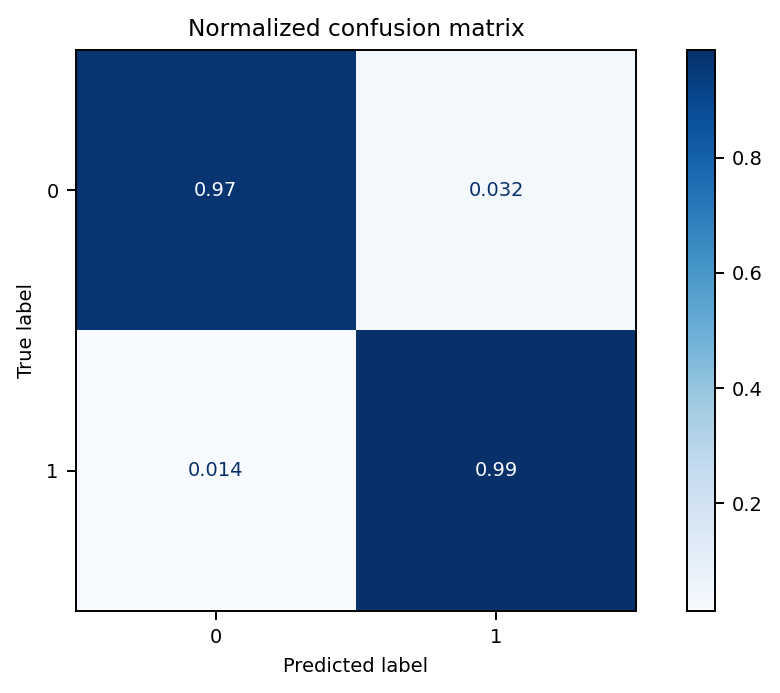

In [ ]:
eval_confusion_matrix_path = os.path.join(eval_path, "val_confusion_matrix.png")
display(Image(filename=eval_confusion_matrix_path))

### Curva ROC

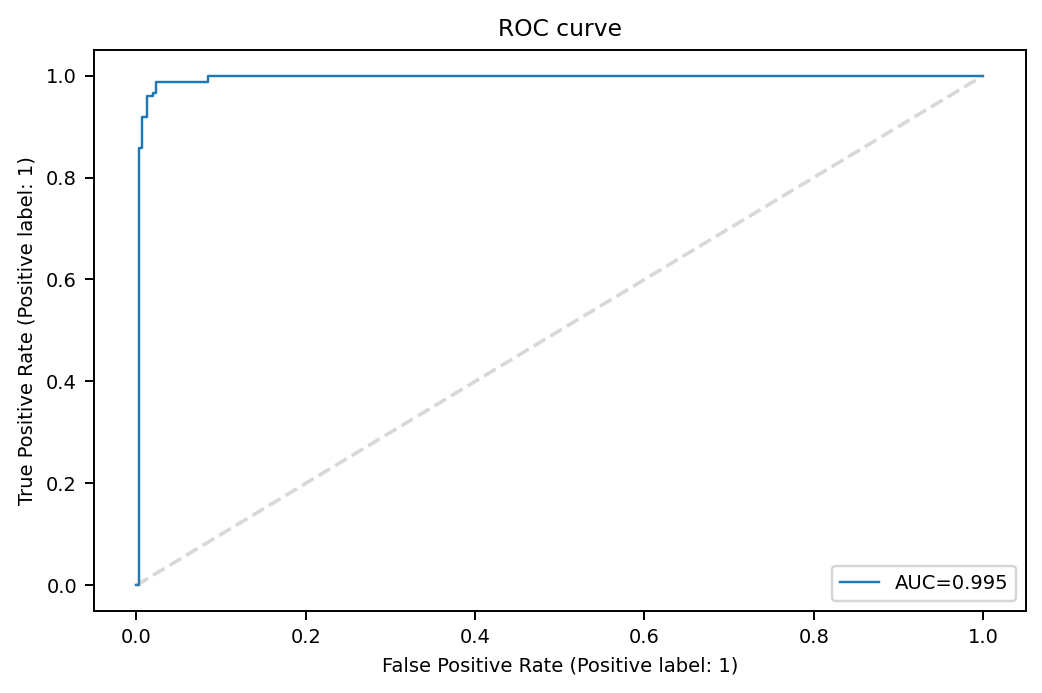

In [ ]:
eval_roc_curve_path = os.path.join(eval_path, "val_roc_curve_plot.png")
display(Image(filename=eval_roc_curve_path))

### Curva Precisão-Recall

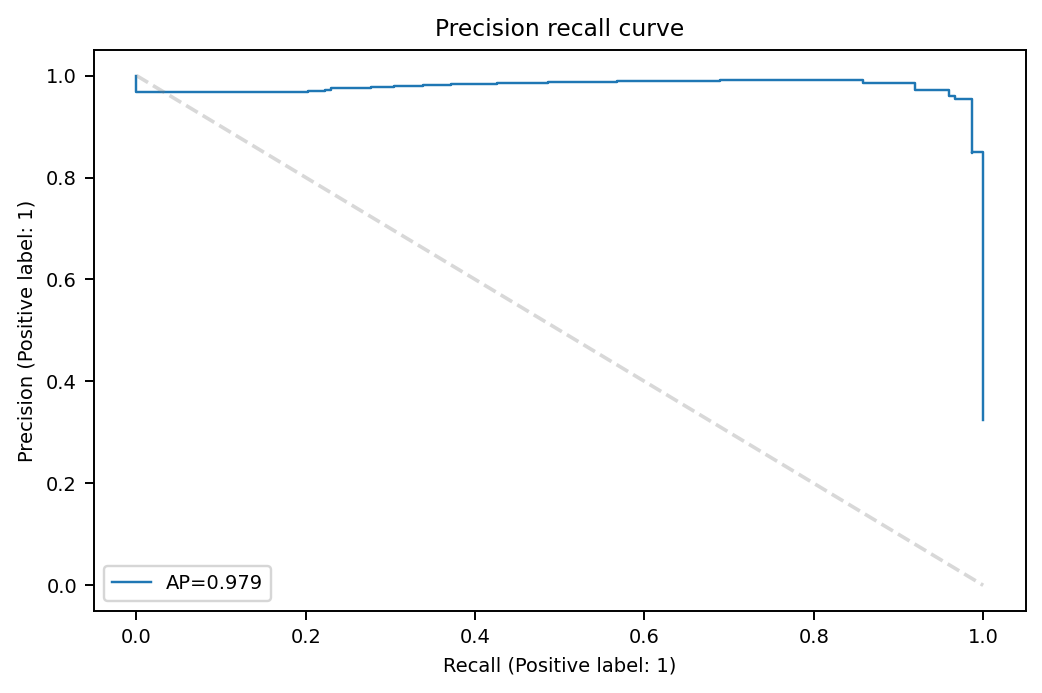

In [ ]:
eval_pr_curve_path = os.path.join(eval_path, "val_precision_recall_curve_plot.png")
display(Image(filename=eval_pr_curve_path))